In [89]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy_healpix as ah
from ligo.skymap.postprocess import find_greedy_credible_levels
m, meta = read_sky_map('/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits')

npix = len(m)
print(npix)

sky_area = 4 * 180**2 / np.pi

nside = hp.npix2nside(npix)
ipix_max = np.argmax(m)
m[ipix_max] / hp.nside2pixarea(nside, degrees=True)
npix = 1891
solid_angle = 4 * np.pi / npix
credible_levels = find_greedy_credible_levels(m)

pixel_area_deg2 = np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print(pixel_area_deg2)
#Convert square degrees to square arcseconds
area_arcsec2 = pixel_area_deg2 * (3600**2)
#Convert square arcseconds to square parsecs using the conversion factor
area_pc2 = area_arcsec2 / (0.2679**2)
#Convert square parsecs to square megaparsecs (Mpc^2)
area_mpc2 = area_pc2 / 10**12
print(area_mpc2)
Volume  = solid_angle * 1000**3
print(Volume)


3145728
7037.477215095633
1.2707981563382371
6645357.2788784625


In [81]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy_healpix as ah

def calculate_pixel_volumes(skymap_file, target_probability=0.1):
    # Read the sky map data
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert HEALPix pixel indices to UNIQ indices
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Match the RA, Dec of the pixels to the sky map UNIQ
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    
    # Initialize arrays to store volumes
    volumes = np.zeros(len(matched_indices))
    # Loop over each matched pixel to calculate volumes
    for i, idx in enumerate(matched_indices):
        pixel_area_deg2 =  hp.nside2pixarea(nside, degrees=True)
        #Convert square degrees to square arcseconds
        area_arcsec2 = pixel_area_deg2 * (3600**2)
        #Convert square arcseconds to square parsecs using the conversion factor
        area_pc2 = area_arcsec2 / (0.2679**2)
        #Convert square parsecs to square megaparsecs (Mpc^2)
        area_mpc2 = area_pc2 / 10**12
        
        dist = 1000
        # Calculate the volume for this pixel
        volumes[i] = (area_mpc2 * dist)*10e-9 # Gpc^3
    
    # Create a structured array to store pixel index, volume, and corresponding distances
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Gpc3', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Gpc3'] = volumes

    
    return pixel_volumes
# Example usage
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'
target_probability = 0.1
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, target_probability)

# Print the first few pixel volumes within the 90% region
for i in range(min(5, len(pixel_volumes_in_90_percent))):
    print(f"Pixel {pixel_volumes_in_90_percent['pixel_index'][i]}: Volume = {pixel_volumes_in_90_percent['volume_Gpc3'][i]:.14f} Gpc^3")
print('Total Volume:', np.sum(pixel_volumes_in_90_percent['volume_Gpc3']), 'Gpc^3')

Pixel 17554: Volume = 0.00000000002368 Gpc^3
Pixel 17553: Volume = 0.00000000002368 Gpc^3
Pixel 17549: Volume = 0.00000000002368 Gpc^3
Pixel 17550: Volume = 0.00000000002368 Gpc^3
Pixel 17543: Volume = 0.00000000002368 Gpc^3
Total Volume: 4.478010050752099e-08 Gpc^3


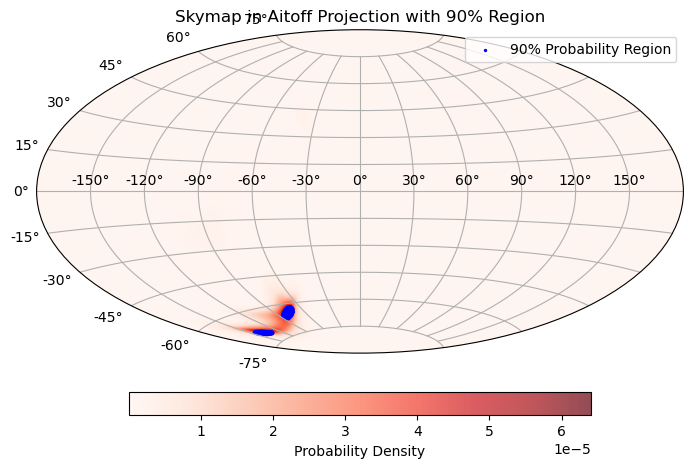

Number of pixels in 90% region: 1891
Matching pixels found: 1891
Number of pixels in 90% region: 1891
Matching pixels found: 1891
Pixel 17554: Volume = 0.000000000023681 Gpc^3
Pixel 17553: Volume = 0.000000000023681 Gpc^3
Pixel 17549: Volume = 0.000000000023681 Gpc^3
Pixel 17550: Volume = 0.000000000023681 Gpc^3
Pixel 17543: Volume = 0.000000000023681 Gpc^3
Total volume in the 90% probability region: 4.4780100508e-08 Gpc^3

Sampled transients in the enclosed region:
SNIa: 0
CCSN: 0
SLSN: 0
KN: 0
GRB_on_axis: 0
GRB_off_axis: 0
CV: 0


In [85]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy_healpix as ah
import numpy as np
import healpy as hp
import astropy_healpix as ah
from astropy.table import QTable
import astropy.units as u
from ligo.skymap.io import read_sky_map
import matplotlib.pyplot as plt

def calculate_sky_area_90_percent(skymap_file, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert pixel indices to RA, Dec
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Find the corresponding UNIQ values directly from skymap
    uniq_values = skymap['UNIQ']
    
    # Calculate the corresponding RA and Dec for the UNIQ values in the skymap
    level, ipix = ah.uniq_to_level_ipix(uniq_values)
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    # Match RA and Dec within some tolerance (e.g., 1e-6 degrees)
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    skymap_pixels_in_target_percent = skymap[matched_indices]
    
    # Calculate area
    pixel_area = hp.nside2pixarea(nside)
    total_area_target_percent = len(pixels_in_target_percent) * pixel_area
    total_area_target_percent_deg2 = total_area_target_percent * (180 / np.pi)**2
    
    plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent)
    # Debug: Print out matching information
    print(f"Number of pixels in 90% region: {len(pixels_in_target_percent)}")
    print(f"Matching pixels found: {len(skymap_pixels_in_target_percent)}")
    
    return total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside

def calculate_pixel_volumes(skymap_file, target_probability=0.1):
    # Read the sky map data
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert HEALPix pixel indices to UNIQ indices
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Match the RA, Dec of the pixels to the sky map UNIQ
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    # Debug: Print out matching information
    print(f"Number of pixels in 90% region: {len(pixels_in_target_percent)}")
    print(f"Matching pixels found: {len(matched_indices)}")
    # Initialize arrays to store volumes
    volumes = np.zeros(len(matched_indices))
    
    # Loop over each matched pixel to calculate volumes
    for i, idx in enumerate(matched_indices):
        pixel_area_deg2 =  hp.nside2pixarea(nside, degrees=True)
        #Convert square degrees to square arcseconds
        area_arcsec2 = pixel_area_deg2 * (3600**2)
        #Convert square arcseconds to square parsecs using the conversion factor
        area_pc2 = area_arcsec2 / (0.2679**2)
        #Convert square parsecs to square megaparsecs (Mpc^2)
        area_mpc2 = area_pc2 / 10**12
        dist = 1000
        # Calculate the volume for this pixel
        volumes[i] = (area_mpc2 * dist)*10e-9 # Gpc^3
    
    # Create a structured array to store pixel index, volume, and corresponding distances
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Gpc3', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Gpc3'] = volumes

    
    return pixel_volumes
    
def calculate_expected_transients(volumes, transients_rates):
    total_expected_transients = {transient: 0 for transient in transients_rates}
    
    for volume in volumes:
        for transient, rate in transients_rates.items():
            expected_events = rate * volume 
            total_expected_transients[transient] += expected_events
    
    return total_expected_transients

def sample_transients(expected_transients):
    sampled_transients = {transient: np.random.poisson(lam=total_count)
                          for transient, total_count in expected_transients.items()}
    return sampled_transients

def plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent):
    # Convert HEALPix coordinates to equatorial coordinates for Aitoff projection
    theta, phi = hp.pix2ang(nside, np.arange(len(m)))
    ra_rad = phi
    dec_rad = 0.5 * np.pi - theta

    # Adjust the range of ra_rad to [-pi, pi] for Aitoff projection
    ra_rad = ra_rad - np.pi

    # Convert the selected pixels back to RA and Dec for plotting
    theta_90, phi_90 = hp.pix2ang(nside, pixels_in_target_percent)
    ra_90 = phi_90 - np.pi
    dec_90 = 0.5 * np.pi - theta_90
    

    # Create the Aitoff projection plot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)

    # Plot the skymap
    sc = ax.scatter(ra_rad, dec_rad, c=m, s=5, cmap='Reds', alpha=0.7, linewidth=0)

    # Plot the specific 90% probability region
    ax.scatter(ra_90, dec_90, color='blue', marker='o', s=2, label='90% Probability Region')

    # Add a colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", fraction=0.06, pad=0.1)
    cbar.set_label('Probability Density')

    plt.title("Skymap in Aitoff Projection with 90% Region")
    plt.legend(loc=1)
    plt.show()

# Ensure the skymap file path is correct
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'  
transients_rates = {
    'SNIa': 2.35e4,  # per Gpc^3 per year
    'CCSN': 1.01e5,
    'SLSN': 5.6,
    'KN': 5e3,
    'GRB_on_axis': 1,
    'GRB_off_axis': 7,
    'CV': 1e6,  # Use a refined rate near the galactic plane
}

# Calculate the 90% area and get the corresponding pixels
total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside = calculate_sky_area_90_percent(skymap_file)

# Calculate volumes for the 90% area
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, target_probability=0.1)

# Print the first few pixel volumes within the 90% region
for i in range(min(5, len(pixel_volumes_in_90_percent))):
    print(f"Pixel {pixel_volumes_in_90_percent['pixel_index'][i]}: Volume = {pixel_volumes_in_90_percent['volume_Gpc3'][i]:.15f} Gpc^3")


# Convert volumes to Gpc^3
volumes_gpc3 = pixel_volumes_in_90_percent['volume_Gpc3'] 

# Sum volumes to get the total volume in the 90% area
total_volume = np.sum(pixel_volumes_in_90_percent['volume_Gpc3']) 
print(f"Total volume in the 90% probability region: {total_volume:.10e} Gpc^3")

# Calculate expected transients in the 90% probability region
total_expected_transients = calculate_expected_transients(volumes_gpc3, transients_rates)

# Sample the number of transients based on expected values
sampled_transients = sample_transients(total_expected_transients)

# Print the sampled number of transients
print("\nSampled transients in the enclosed region:")
for transient, sampled_count in sampled_transients.items():
    print(f"{transient}: {sampled_count}")

# With Time Window

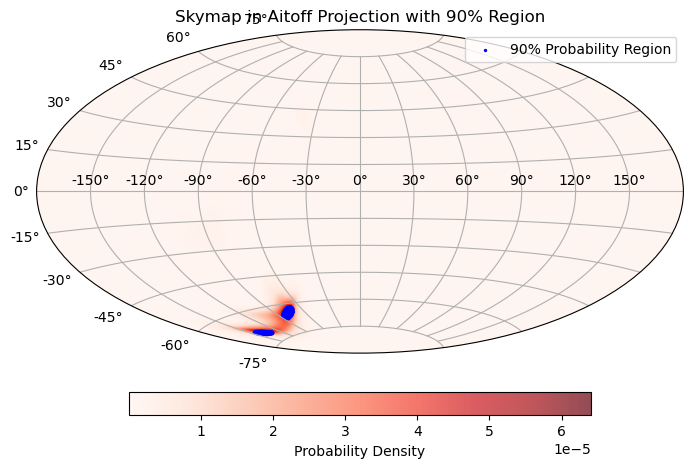

Pixel 17554: Volume = 0.000000000023681 Gpc^3
Pixel 17553: Volume = 0.000000000023681 Gpc^3
Pixel 17549: Volume = 0.000000000023681 Gpc^3
Pixel 17550: Volume = 0.000000000023681 Gpc^3
Pixel 17543: Volume = 0.000000000023681 Gpc^3
Total volume in the 90% probability region: 4.4780100508e-08 Gpc^3

Sampled transients in the enclosed region:
SNIa: 0
CCSN: 0
SLSN: 0
KN: 0
GRB_on_axis: 0
GRB_off_axis: 0
CV: 0


In [117]:
import numpy as np
import healpy as hp
import astropy_healpix as ah
from astropy.table import QTable
import astropy.units as u
from ligo.skymap.io import read_sky_map
import matplotlib.pyplot as plt

def calculate_sky_area_90_percent(skymap_file, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert pixel indices to RA, Dec
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Find the corresponding UNIQ values directly from skymap
    uniq_values = skymap['UNIQ']
    
    # Calculate the corresponding RA and Dec for the UNIQ values in the skymap
    level, ipix = ah.uniq_to_level_ipix(uniq_values)
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    # Match RA and Dec within some tolerance (e.g., 1e-6 degrees)
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    skymap_pixels_in_target_percent = skymap[matched_indices]
    
    # Calculate area
    pixel_area = hp.nside2pixarea(nside)
    total_area_target_percent = len(pixels_in_target_percent) * pixel_area
    total_area_target_percent_deg2 = total_area_target_percent * (180 / np.pi)**2
    
    plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent)
    
    return total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside

def calculate_pixel_volumes(skymap_file, target_probability=0.1):
    # Read the sky map data
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert HEALPix pixel indices to UNIQ indices
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Match the RA, Dec of the pixels to the sky map UNIQ
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    
    # Initialize arrays to store volumes
    volumes = np.zeros(len(matched_indices))
    
    # Loop over each matched pixel to calculate volumes
    for i, idx in enumerate(matched_indices):
        pixel_area_deg2 =  hp.nside2pixarea(nside, degrees=True)
        #Convert square degrees to square arcseconds
        area_arcsec2 = pixel_area_deg2 * (3600**2)
        #Convert square arcseconds to square parsecs using the conversion factor
        area_pc2 = area_arcsec2 / (0.2679**2)
        #Convert square parsecs to square megaparsecs (Mpc^2)
        area_mpc2 = area_pc2 / 10**12
        
        dist = 1000
        # Calculate the volume for this pixel
        volumes[i] = (area_mpc2 * dist)*10e-9  # Gpc^3
    
    # Create a structured array to store pixel index, volume, and corresponding distances
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Gpc3', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Gpc3'] = volumes

    
    return pixel_volumes
    
def calculate_expected_transients_poisson(volumes, transients_rates, time_window_days=2):
    total_expected_transients = {transient: 0 for transient in transients_rates}
    time_window_years = time_window_days / 365.25  # Convert time window to years
    
    for volume in volumes:  # Iterate directly over the volumes array
        for transient, rate in transients_rates.items():
            T = time_window_years  # Use the time window in years
            expected_events = rate * volume * T  # Rate is per Gpc^3 per year, volume is in Gpc^3
            
            # Poisson sampling based on the expected number of events
            sampled_events = np.random.poisson(expected_events)
            total_expected_transients[transient] += sampled_events
    
    return total_expected_transients

def plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent):
    # Convert HEALPix coordinates to equatorial coordinates for Aitoff projection
    theta, phi = hp.pix2ang(nside, np.arange(len(m)))
    ra_rad = phi
    dec_rad = 0.5 * np.pi - theta

    # Adjust the range of ra_rad to [-pi, pi] for Aitoff projection
    ra_rad = ra_rad - np.pi

    # Convert the selected pixels back to RA and Dec for plotting
    theta_90, phi_90 = hp.pix2ang(nside, pixels_in_target_percent)
    ra_90 = phi_90 - np.pi
    dec_90 = 0.5 * np.pi - theta_90
    
    # Create the Aitoff projection plot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)

    # Plot the skymap
    sc = ax.scatter(ra_rad, dec_rad, c=m, s=5, cmap='Reds', alpha=0.7, linewidth=0)

    # Plot the specific 90% probability region
    ax.scatter(ra_90, dec_90, color='blue', marker='o', s=2, label='90% Probability Region')

    # Add a colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", fraction=0.06, pad=0.1)
    cbar.set_label('Probability Density')

    plt.title("Skymap in Aitoff Projection with 90% Region")
    plt.legend(loc=1)
    plt.show()

# Ensure the skymap file path is correct
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'  
transients_rates = {
    'SNIa': 2.35e4,  # per Gpc^3 per year
    'CCSN': 1.01e5,
    'SLSN': 5.6,
    'KN': 5e3,
    'GRB_on_axis': 1,
    'GRB_off_axis': 7,
    'CV': 1e6,  # Use a refined rate near the galactic plane
}
time_window_days = 2
# Calculate the 90% area and get the corresponding pixels
total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside = calculate_sky_area_90_percent(skymap_file)

# Calculate volumes for the 90% area
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, target_probability=0.1)

# Print the first few pixel volumes within the 90% region
for i in range(min(5, len(pixel_volumes_in_90_percent))):
    print(f"Pixel {pixel_volumes_in_90_percent['pixel_index'][i]}: Volume = {pixel_volumes_in_90_percent['volume_Gpc3'][i]:.15f} Gpc^3")


# Convert volumes to Gpc^3
volumes_gpc3 = pixel_volumes_in_90_percent['volume_Gpc3'] 

# Sum volumes to get the total volume in the 90% area
total_volume = np.sum(pixel_volumes_in_90_percent['volume_Gpc3']) 
print(f"Total volume in the 90% probability region: {total_volume:.10e} Gpc^3")

# Calculate expected transients in the 90% probability region
total_expected_transients = calculate_expected_transients_poisson(volumes_gpc3, transients_rates)

# Sample the number of transients based on expected values
# Print the sampled number of transients
print("\nSampled transients in the enclosed region:")
for transient, sampled_count in total_expected_transients.items():
    print(f"{transient}: {sampled_count}")


# 100 simulations

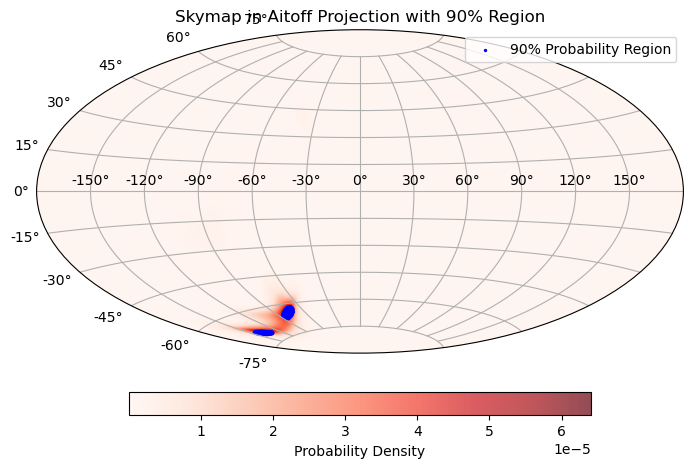


Mean and standard deviation of sampled transients over 100 simulations:
SNIa: Mean = 0.000000000000000, Std = 0.000000000000000
CCSN: Mean = 0.000000000000000, Std = 0.000000000000000
SLSN: Mean = 0.000000000000000, Std = 0.000000000000000
KN: Mean = 0.000000000000000, Std = 0.000000000000000
GRB_on_axis: Mean = 0.000000000000000, Std = 0.000000000000000
GRB_off_axis: Mean = 0.000000000000000, Std = 0.000000000000000
CV: Mean = 0.000000000000000, Std = 0.000000000000000


In [118]:
import numpy as np
import healpy as hp
import astropy_healpix as ah
from astropy.table import QTable
import astropy.units as u
from ligo.skymap.io import read_sky_map
import matplotlib.pyplot as plt

# Define the functions as before
# (These functions are unchanged from the previous code)
def calculate_sky_area_90_percent(skymap_file, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    nside = meta.get('nside', hp.get_nside(m))
    
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    uniq_values = skymap['UNIQ']
    
    level, ipix = ah.uniq_to_level_ipix(uniq_values)
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    skymap_pixels_in_target_percent = skymap[matched_indices]
    
    pixel_area = hp.nside2pixarea(nside)
    total_area_target_percent = len(pixels_in_target_percent) * pixel_area
    total_area_target_percent_deg2 = total_area_target_percent * (180 / np.pi)**2
    
    plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent)
    
    return total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside

def calculate_pixel_volumes(skymap_file, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    nside = meta.get('nside', hp.get_nside(m))
    
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    
    volumes = np.zeros(len(matched_indices))
    
     # Loop over each matched pixel to calculate volumes
    for i, idx in enumerate(matched_indices):
        pixel_area_deg2 =  hp.nside2pixarea(nside, degrees=True)
        #Convert square degrees to square arcseconds
        area_arcsec2 = pixel_area_deg2 * (3600**2)
        #Convert square arcseconds to square parsecs using the conversion factor
        area_pc2 = area_arcsec2 / (0.2679**2)
        #Convert square parsecs to square megaparsecs (Mpc^2)
        area_mpc2 = area_pc2 / 10**12
        
        dist = 1000
        # Calculate the volume for this pixel
        volumes[i] = (area_mpc2 * dist)*10e-9    # Gpc^3
    
    # Create a structured array to store pixel index, volume, and corresponding distances
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Gpc3', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Gpc3'] = volumes

    
    return pixel_volumes
    
def calculate_expected_transients_poisson(volumes, transients_rates, time_window_days=2):
    total_expected_transients = {transient: 0 for transient in transients_rates}
    time_window_years = time_window_days / 365.25
    
    for volume in volumes:
        for transient, rate in transients_rates.items():
            T = time_window_years
            expected_events = rate * volume * T
            
            sampled_events = np.random.poisson(expected_events)
            total_expected_transients[transient] += sampled_events
    
    return total_expected_transients

def plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent):
    theta, phi = hp.pix2ang(nside, np.arange(len(m)))
    ra_rad = phi
    dec_rad = 0.5 * np.pi - theta

    ra_rad = ra_rad - np.pi

    theta_90, phi_90 = hp.pix2ang(nside, pixels_in_target_percent)
    ra_90 = phi_90 - np.pi
    dec_90 = 0.5 * np.pi - theta_90
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)

    sc = ax.scatter(ra_rad, dec_rad, c=m, s=5, cmap='Reds', alpha=0.7, linewidth=0)

    ax.scatter(ra_90, dec_90, color='blue', marker='o', s=2, label='90% Probability Region')

    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", fraction=0.06, pad=0.1)
    cbar.set_label('Probability Density')

    plt.title("Skymap in Aitoff Projection with 90% Region")
    plt.legend(loc=1)
    plt.show()

# Ensure the skymap file path is correct
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'  
transients_rates = {
    'SNIa': 2.35e4,  # per Gpc^3 per year
    'CCSN': 1.01e5,
    'SLSN': 5.6,
    'KN': 5e3,
    'GRB_on_axis': 1,
    'GRB_off_axis': 7,
    'CV': 1e6,  # Use a refined rate near the galactic plane
}

# Calculate the 90% area and get the corresponding pixels
total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside = calculate_sky_area_90_percent(skymap_file)

# Calculate volumes for the 90% area
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, target_probability=0.1)

# Run multiple simulations
num_simulations = 100
all_simulations = {transient: [] for transient in transients_rates}

time_window_days = 2  # Define the time window

for _ in range(num_simulations):
    # Calculate expected transients in the 90% probability region with time window integration
    total_expected_transients = calculate_expected_transients_poisson(pixel_volumes_in_90_percent['volume_Gpc3'], transients_rates, time_window_days)
    
    # Store the results of each simulation
    for transient, count in total_expected_transients.items():
        all_simulations[transient].append(count)

# Calculate mean and standard deviation for each transient type
mean_transients = {transient: np.mean(all_simulations[transient]) for transient in transients_rates}
std_transients = {transient: np.std(all_simulations[transient]) for transient in transients_rates}

# Print the results
print("\nMean and standard deviation of sampled transients over 100 simulations:")
for transient in transients_rates:
    print(f"{transient}: Mean = {mean_transients[transient]:.15f}, Std = {std_transients[transient]:.15f}")


# Volume with redshift dependence

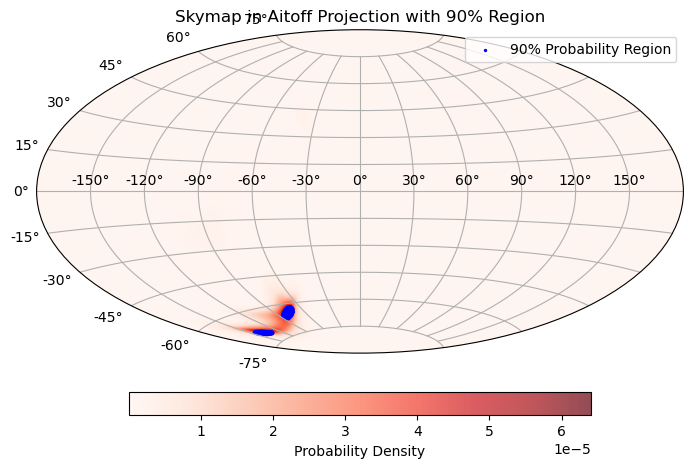

Pixel 17554: Volume = 0.000000253899227 Gpc^3
Pixel 17553: Volume = 0.000000253899227 Gpc^3
Pixel 17549: Volume = 0.000000253899227 Gpc^3
Pixel 17550: Volume = 0.000000253899227 Gpc^3
Pixel 17543: Volume = 0.000000253899227 Gpc^3
Total volume in the 90% probability region: 4.8012343860e-04 Gpc^3

Sampled transients in the enclosed region:
SNIa: 9
CCSN: 53
SLSN: 0
KN: 1
GRB_on_axis: 0
GRB_off_axis: 0
CV: 479


In [17]:
import numpy as np
import healpy as hp
import lal
import astropy_healpix as ah
from astropy.table import QTable
import astropy.units as u
from ligo.skymap.io import read_sky_map
from astropy.cosmology import Planck18 as cosmo
import matplotlib.pyplot as plt

def calculate_sky_area_90_percent(skymap_file, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert pixel indices to RA, Dec
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Find the corresponding UNIQ values directly from skymap
    uniq_values = skymap['UNIQ']
    
    # Calculate the corresponding RA and Dec for the UNIQ values in the skymap
    level, ipix = ah.uniq_to_level_ipix(uniq_values)
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    skymap_pixels_in_target_percent = skymap[matched_indices]
    
    # Calculate area
    pixel_area = hp.nside2pixarea(nside)
    total_area_target_percent = len(pixels_in_target_percent) * pixel_area
    total_area_target_percent_deg2 = total_area_target_percent * (180 / np.pi)**2
    
    plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent)
    
    return total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside

def pixel_volume_at_redshift(area_arcsec2, z_min, z_max):
    # Convert area from arcseconds^2 to Mpc^2
    angular_diameter_distance = cosmo.angular_diameter_distance(z_min)  # Assuming z_min for simplicity
    area_mpc2 = area_arcsec2 * (angular_diameter_distance.value / 206265.0)**2
    
    # Calculate comoving distance at z_min and z_max
    d_c_min = cosmo.comoving_distance(z_min).value
    d_c_max = cosmo.comoving_distance(z_max).value
    
    
    # Calculate the volume
    volume = area_mpc2 * (d_c_max - d_c_min)
    
    return volume

def calculate_pixel_volumes(skymap_file, z_min=0.1, z_max=0.2, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    nside = meta.get('nside', hp.get_nside(m))
    
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert HEALPix pixel indices to UNIQ indices
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    
    volumes = np.zeros(len(matched_indices))
    
    for i, idx in enumerate(matched_indices):
        pixel_area_deg2 =  hp.nside2pixarea(nside, degrees=True)
        area_arcsec2 = pixel_area_deg2 * (3600**2)
        
        volumes[i] = pixel_volume_at_redshift(area_arcsec2, z_min, z_max)
    
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Gpc3', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Gpc3'] = volumes * 1e-9  # Convert to Gpc^3
    
    return pixel_volumes

def calculate_expected_transients(volumes, transients_rates):
    total_expected_transients = {transient: 0 for transient in transients_rates}
    
    for volume in volumes:
        for transient, rate in transients_rates.items():
            expected_events = rate * volume
            total_expected_transients[transient] += expected_events
    
    return total_expected_transients

def sample_transients(expected_transients):
    sampled_transients = {transient: np.random.poisson(lam=total_count)
                          for transient, total_count in expected_transients.items()}
    return sampled_transients

def plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent):
    theta, phi = hp.pix2ang(nside, np.arange(len(m)))
    ra_rad = phi
    dec_rad = 0.5 * np.pi - theta
    ra_rad = ra_rad - np.pi

    theta_90, phi_90 = hp.pix2ang(nside, pixels_in_target_percent)
    ra_90 = phi_90 - np.pi
    dec_90 = 0.5 * np.pi - theta_90
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)
    
    sc = ax.scatter(ra_rad, dec_rad, c=m, s=5, cmap='Reds', alpha=0.7, linewidth=0)
    ax.scatter(ra_90, dec_90, color='blue', marker='o', s=2, label='90% Probability Region')
    
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", fraction=0.06, pad=0.1)
    cbar.set_label('Probability Density')

    plt.title("Skymap in Aitoff Projection with 90% Region")
    plt.legend(loc=1)
    plt.show()

# Ensure the skymap file path is correct
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'
transients_rates = {
    'SNIa': 2.35e4,  # per Gpc^3 per year
    'CCSN': 1.01e5,
    'SLSN': 5.6,
    'KN': 5e3,
    'GRB_on_axis': 1,
    'GRB_off_axis': 7,
    'CV': 1e6,  # Use a refined rate near the galactic plane
}

# Calculate the 90% area and get the corresponding pixels
total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside = calculate_sky_area_90_percent(skymap_file)

# Calculate volumes for the 90% area using redshift sensitivity
z_min = 0.1
z_max = 0.2
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, z_min, z_max, target_probability=0.1)

# Print the first few pixel volumes within the 90% region
for i in range(min(5, len(pixel_volumes_in_90_percent))):
    print(f"Pixel {pixel_volumes_in_90_percent['pixel_index'][i]}: Volume = {pixel_volumes_in_90_percent['volume_Gpc3'][i]:.15f} Gpc^3")

# Sum volumes to get the total volume in the 90% area
total_volume = np.sum(pixel_volumes_in_90_percent['volume_Gpc3'])
print(f"Total volume in the 90% probability region: {total_volume:.10e} Gpc^3")

# Calculate expected transients in the 90% probability region
total_expected_transients = calculate_expected_transients(pixel_volumes_in_90_percent['volume_Gpc3'], transients_rates)

# Sample the number of transients based on expected values
sampled_transients = sample_transients(total_expected_transients)

# Print the sampled number of transients
print("\nSampled transients in the enclosed region:")
for transient, sampled_count in sampled_transients.items():
    print(f"{transient}: {sampled_count}")
